## A tour of MLJ

### Models, machines, networks and tasks

Let's load data and define train and test rows:

In [79]:
using MLJ
using DataFrames, Statistics
using Suppressor
using Plots
pyplot()
data_r = rand(300,3)
y = exp(data_r[:,1] - data_r[:,2] - 2data_r[:,3] + 0.1*rand(300))
X = DataFrame(data_r)

train, test = partition(eachindex(y), 0.70); # 70:30 split

A *model* is a container for hyperparameters:

Beyond built-in packages (such as KNN), we currently support models from packages such as DecisionTree, RandomForest, XGBoost.

We also allow for integration with other toolboxes such as ScikitLearn.

In [80]:
knn_model=KNNRegressor(K=10)

KNNRegressor(K = 10,
             metric = MLJ.KNN.euclidean,
             kernel = MLJ.KNN.reciprocal,) @ 6…22

Wrapping the model in data creates a *machine* which will store training outcomes.

In [81]:
 knn = machine(knn_model, X, y)

Machine{KNNRegressor} @ 1…92


Training on the training rows and evaluating on the test rows:

In [82]:
@suppress fit!(knn, rows=train)
yhat = predict(knn, X[test,:])
rms(yhat, y[test])

0.06767723393522979

Or, we could have skipped the train/test definitions and evaluated one line:

In [83]:
@suppress evaluate!(knn, resampling=Holdout(fraction_train=0.7), measure=rms)

0.06767723393522979

Our machine/model constructions and associated fit/predict syntax anticipates a powerful extension for building networks of learners described later. Changing a hyperparameter and re-evaluating:

In [84]:
knn_model.K = 20
@suppress evaluate!(knn, resampling=Holdout(fraction_train=0.7))  # `default_measure(knn) == rms` so `measure` kwarg can be dropped

0.08494551791681808

### Homogeneous ensembles

Here's an ensemble model for 20 K-nearest neighbour regressors:

In [85]:
ensemble_model = EnsembleModel(atom=knn_model, n=20)

MLJ.DeterministicEnsembleModel(atom = KNNRegressor{} @ 6…22,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x16bb9e37, 0xf0414ffc, 0x69207e09, 0x18e59459]),
                               n = 20,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 1…09

It can be trained and tested the same as any other model

We can also create a machine containing the model and the data

In [86]:
ensemble = machine(ensemble_model, X, y)
estimates = @suppress evaluate!(ensemble, resampling=CV())

6-element Array{Float64,1}:
 0.1258809276752408 
 0.14354045040757532
 0.07950139192021495
 0.08174842717234924
 0.10494717848635321
 0.0588568376647965 

In [87]:
mean(estimates)

0.09907920222108835

### Systematic tuning

Let's simultaneously tune the ensemble's `bagging_fraction` and the K-nearest neighbour hyperparameter `K`. Since one of our models is a field of the other, we have nested hyperparameters:

In [88]:
params(ensemble_model) # extract model hyperparameters as nested named tuple

(atom = (K = 20,
         metric = MLJ.KNN.euclidean,
         kernel = MLJ.KNN.reciprocal,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x16bb9e37, 0xf0414ffc, 0x69207e09, 0x18e59459]),
 n = 20,
 parallel = true,
 out_of_bag_measure = Any[],)

To define a tuning grid, we construct ranges for parameters and collate these ranges following the same pattern above (omitting parameters that don't change), allowing us to tune in parallel 

In [89]:
B_range = range(ensemble_model, :bagging_fraction, lower= 0.5, upper=1.0, scale = :linear)
K_range = range(knn_model, :K, lower=1, upper=100, scale=:log10)
nested_ranges = (atom = (K = K_range,), 
                 bagging_fraction = B_range)

(atom = (K = NumericRange{K} @ 3…03,),
 bagging_fraction = NumericRange{bagging_fraction} @ 9…55,)

Now we choose a tuning strategy:

In [90]:
tuning = Grid(resolution=12)

Grid(resolution = 12,
     parallel = true,) @ 1…40

And a resampling strategy:

In [91]:
resampling = Holdout(fraction_train=0.8)

Holdout(fraction_train = 0.8,
        shuffle = false,) @ 6…99

And define a new model which wraps the these strategies around our ensemble model:

In [92]:
tuned_ensemble_model = TunedModel(model=ensemble_model, 
    tuning=tuning, resampling=resampling, nested_ranges=nested_ranges)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel{KNNRegressor} @ 1…09,
                            tuning = Grid{} @ 1…40,
                            resampling = Holdout{} @ 6…99,
                            measure = nothing,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (K = NumericRange{K} @ 3…03,), bagging_fraction = NumericRange{bagging_fraction} @ 9…55),
                            minimize = true,
                            full_report = true,) @ 9…11

Fitting the corresponding machine tunes the underlying model (in this case an ensemble) and retrains on all supplied data:

In [93]:
tuned_ensemble = machine(tuned_ensemble_model, X[train,:], y[train])
@suppress fit!(tuned_ensemble);

For each fitted machine, one may inspect a user-friendly version of the fitted parameters (as opposed to the hyperparameters stored in its model). In the current case this is the best ensemble model (trained on all available data):

In [94]:
fitted_params(tuned_ensemble)

(best_model = DeterministicEnsembleModel{KNNRegressor} @ 7…35,)

In [95]:
params(ans.best_model)

(atom = (K = 1,
         metric = MLJ.KNN.euclidean,
         kernel = MLJ.KNN.reciprocal,),
 weights = Float64[],
 bagging_fraction = 0.6363636363636364,
 rng = MersenneTwister(UInt32[0x16bb9e37, 0xf0414ffc, 0x69207e09, 0x18e59459]),
 n = 20,
 parallel = true,
 out_of_bag_measure = Any[],)

The `report` method gives more detail on the tuning process:

In [31]:
report(tuned_ensemble) 

(parameter_names = ["atom.K" "bagging_fraction"],
 parameter_scales = Symbol[:log10 :linear],
 parameter_values = Any[1 0.5; 2 0.5; … ; 66 1.0; 100 1.0],
 measurements = [0.0763391, 0.0658622, 0.0765743, 0.0793259, 0.093009, 0.107118, 0.149813, 0.184016, 0.238952, 0.31457  …  0.090645, 0.074644, 0.0761809, 0.0704965, 0.0787269, 0.0952186, 0.117432, 0.156369, 0.20538, 0.261983],
 best_measurement = 0.06489009388972176,)

Or for a plot of tuning results:

Plotting capabilities provided by an external contributor,  **Michael Krabbe Borregaard**

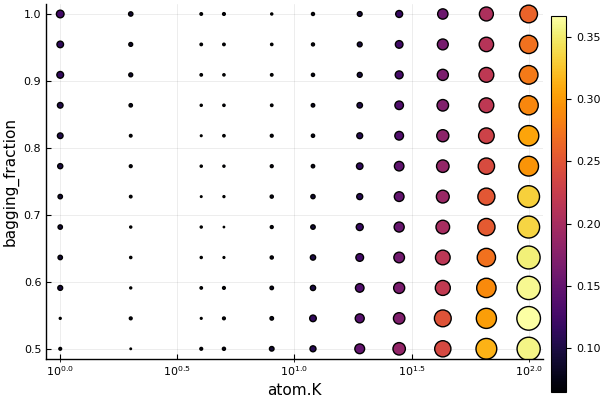

In [32]:
using Plots
pyplot()
plot(tuned_ensemble)

Evaluating the model:

In [33]:
yhat = predict(tuned_ensemble, X[test,:])
rms(yhat, y[test])

0.0502687282938968

Or, using all the data, get cross-validation estimates, with cv-tuning on each fold complement (nested resampling):

In [34]:
tuned_ensemble = machine(tuned_ensemble_model, X, y)
estimates = @suppress evaluate!(tuned_ensemble, resampling=CV(nfolds=4), verbosity=2)

4-element Array{Float64,1}:
 0.06425426915557467
 0.17099203576397076
 0.06986785358367349
 0.0546625654886799 

In [35]:
mean(estimates)

0.08994418099797472

### Learning networks , Stacking and Ensembling

![](two_model_stack.png)


To implement the network, we begin by loading all data needed for training and evaluation into *source nodes*:

In [36]:
Xs = source(X)
ys = source(y)

Source @ 4…48

We label nodes according to our model / diagram

To construct the `W` node we first need to define the machine `stand` that it will use to transform inputs. 

In [37]:
stand_model = Standardizer()
stand = machine(stand_model, Xs)

NodalMachine @ 1…99 = machine(Standardizer{} @ 1…39, 1…96)

Because `Xs` is a node, instead of concrete data, we can call `transform` on the machine without first training it, and the result is a new node.
To get actual transformed data we *call* the node appropriately, which will require we first train the node.

In [38]:
W = transform(stand, Xs)
@suppress fit!(W, rows=train)


Node @ 2…39 = transform(1…99, 1…96)

The other nodes of our network are defined similarly:

In [44]:
box_model = UnivariateBoxCoxTransformer()  # for making data look normally-distributed
box = machine(box_model, ys)
z = transform(box, ys)

ridge_model = RidgeRegressor(lambda=0.1)
ridge =machine(ridge_model, W, z)
zhat = predict(ridge, W)

yhat = inverse_transform(box, zhat)

Node @ 5…93 = inverse_transform(5…94, predict(1…94, transform(1…99, 1…96)))

We are ready to train and evaluate the completed network. Notice that the standardizer, `stand`, is *not* retrained, as MLJ remembers that it was trained earlier:

In [46]:
fit!(yhat, rows=train)
rms(y[test], yhat(rows=test)) # evaluate

┌ Info: Not retraining NodalMachine{UnivariateBoxCoxTransformer} @ 5…94. It is up-to-date.
└ @ MLJ /Users/ysimillides/.julia/packages/MLJ/w0rRg/src/networks.jl:227
┌ Info: Not retraining NodalMachine{Standardizer} @ 1…99. It is up-to-date.
└ @ MLJ /Users/ysimillides/.julia/packages/MLJ/w0rRg/src/networks.jl:227
┌ Info: Not retraining NodalMachine{RidgeRegressor} @ 1…94. It is up-to-date.
└ @ MLJ /Users/ysimillides/.julia/packages/MLJ/w0rRg/src/networks.jl:227


0.014940384501084201

In [47]:
yhat(X[3:4,:])  # predict on new or old data

2-element Array{Float64,1}:
 0.21474903698396683
 0.502142474959435  

We can change hyperparameters and retrain:

In [49]:
ridge_model.lambda = 0.01
@suppress fit!(yhat, rows=train) 
rms(y[test], yhat(rows=test))

0.014929960090693563

We proceed to demonstrate the task interface, where we load in a pre-defined task (one can also define their own task to evaluate against our models).

In [78]:
task = load_boston()

load_boston = CSV.read(joinpath(datadir, "Boston.csv"), copycols=true,
                 categorical=true, allowmissing=:none)
   return SupervisedTask(verbosity=0, data=df,
                         target=:MedV,
                         ignore=[:Chas,],
                         is_probabilistic=false)

SupervisedTask{} @ 1…31


We can see which models correspond to our task

In [51]:
models(task)

Dict{String,Any} with 5 entries:
  "MultivariateStats" => Any["RidgeRegressor"]
  "MLJ"               => Any["KNNRegressor", "RidgeRegressor"]
  "DecisionTree"      => Any["DecisionTreeRegressor"]
  "ScikitLearn"       => Any["ElasticNet", "ElasticNetCV", "SVMRegressor", "SVM…
  "XGBoost"           => Any["XGBoostRegressor"]

In [52]:
@load DecisionTreeRegressor
info(DecisionTreeRegressor)

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeRegressor ✔


Dict{Symbol,Any} with 12 entries:
  :is_pure_julia         => true
  :input_is_multivariate => true
  :is_wrapper            => false
  :package_uuid          => "7806a523-6efd-50cb-b5f6-3fa6f1930dbb"
  :target_scitype_union  => Continuous
  :package_url           => "https://github.com/bensadeghi/DecisionTree.jl"
  :name                  => "DecisionTreeRegressor"
  :is_supervised         => true
  :is_probabilistic      => false
  :load_path             => "MLJModels.DecisionTree_.DecisionTreeRegressor"
  :input_scitype_union   => Continuous
  :package_name          => "DecisionTree"

# Evaluate a single DecisionTree

In [73]:
tree = DecisionTreeRegressor()
mach = machine(tree, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms,rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/ysimillides/.julia/packages/MLJ/w0rRg/src/resampling.jl:91


(MLJ.rms = 7.054322052311654,
 MLJ.rmslp1 = 0.32730942581047084,)

# Create a Random Forest by ensembling

In [54]:
forest = EnsembleModel(atom=tree)


MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor{} @ 6…65,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x16bb9e37, 0xf0414ffc, 0x69207e09, 0x18e59459]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 4…56

We start by reducing number of features sampled at each tree node.


In [55]:
tree.n_subfeatures = 3;


To get an idea of how many trees we need, we wrap our forest model in the task, pick a range for the ensemble size, n, and generate learning curves (plots of model performance against n):


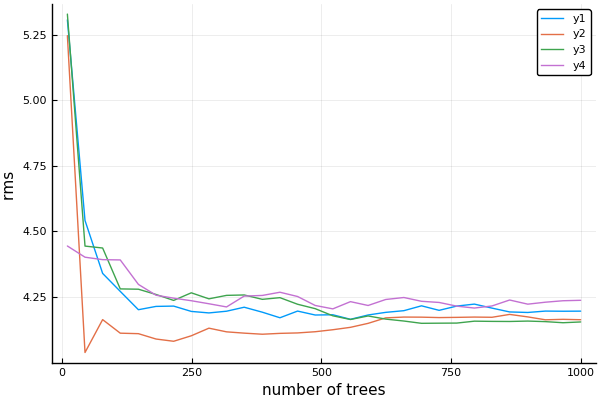

In [76]:
mach = machine(forest, task)
r = range(forest, :n, lower=10, upper=1000)
curves = learning_curve!(mach,
    resampling=Holdout(fraction_train=0.8),
    nested_range=(n=r,), 
    measure=rms, n=4,
    verbosity=0)
plot(curves.parameter_values, curves.measurements,
     xlab="number of trees", ylab="rms ")


# Tuning
A forest is a composite model, it has nested hyperparameters

In [57]:
params(forest) # all hyperparameters, as a named tuple


(atom = (pruning_purity_threshold = 0.0,
         max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x16bb9e37, 0xf0414ffc, 0x69207e09, 0x18e59459]),
 n = 300,
 parallel = true,
 out_of_bag_measure = Any[],)

We define ranges for the hyperparameters we wish to tune

In [58]:
r1 = range(tree, :n_subfeatures, lower=1, upper=12)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);

In [59]:
nested_ranges = (atom=(n_subfeatures=r1,), 
                 bagging_fraction=r2)

(atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…90,),
 bagging_fraction = NumericRange{bagging_fraction} @ 1…89,)

We now wrap our forest in tuning strategy to obtain a new model


In [60]:
tuned_forest = TunedModel(model=forest, 
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          nested_ranges=nested_ranges, 
                          measure=rms)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel{DecisionTreeRegressor} @ 4…56,
                            tuning = Grid{} @ 1…21,
                            resampling = CV{} @ 1…64,
                            measure = MLJ.rms,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…90,), bagging_fraction = NumericRange{bagging_fraction} @ 1…89),
                            minimize = true,
                            full_report = true,) @ 1…38

In [61]:
params(tuned_forest)


(model = (atom = (pruning_purity_threshold = 0.0,
                  max_depth = -1,
                  min_samples_leaf = 5,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 3,
                  post_prune = false,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng = MersenneTwister(UInt32[0x16bb9e37, 0xf0414ffc, 0x69207e09, 0x18e59459]),
          n = 300,
          parallel = true,
          out_of_bag_measure = Any[],),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 6,
               parallel = true,
               shuffle = false,),
 measure = MLJ.rms,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…90,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 1…89,),
 minimize = true,
 full_report = true,)

# Evaluating the self-tuning random forest
We evaluate our self-tuning random forest the same as any other model:


In [62]:
mach = machine(tuned_forest, task)
@suppress evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1])

(MLJ.rms = 4.059052685131962,
 MLJ.rmslp1 = 0.256077821084878,)

We can view the optimal hyperparameters

In [63]:
fitted_params(mach)

best = fitted_params(mach).best_model
@show best.bagging_fraction
@show best.atom.n_subfeatures;

best.bagging_fraction = 0.5636363636363636
(best.atom).n_subfeatures = 7


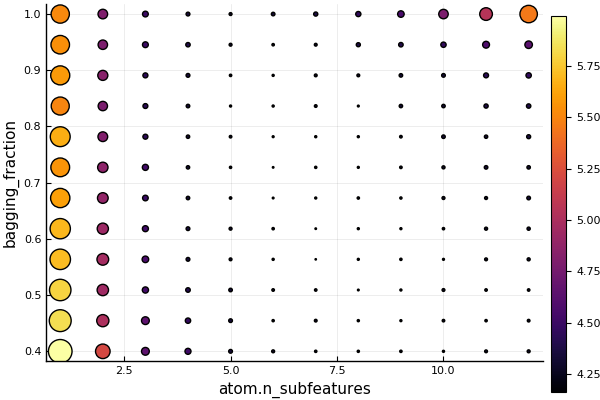

In [64]:
plot(mach)
